# 🏆 เปรียบเทียบ 3 วิธีทำนาย Time Series

## Linear Regression vs ANN vs RNN

**วัตถุประสงค์:** เปรียบเทียบความแม่นยำและข้อดี-ข้อเสีย

### 🎯 3 วิธีที่จะเปรียบเทียบ

| วิธี | ความซับซ้อน | คำนึงถึงเวลา | ผลลัพธ์คาดหวัง |
|------|------------|-------------|----------------|
| **📏 Linear Regression** | ต่ำ | ❌ | Baseline (R² ~0.70) |
| **🧠 ANN** | ปานกลาง | ❌ | ดีขึ้น (R² ~0.91) |
| **🔄 RNN (GRU)** | สูง | ✅ | ดีที่สุด (R² ~0.93) |

### 📊 ข้อมูล
- **Dataset:** จำนวนผู้โดยสารสายการบิน 1949-1960
- **จำนวน:** 144 เดือน
- **Task:** ทำนายเดือนถัดไป จาก D เดือนก่อนหน้า

---

## 📦 Part 1: เตรียมความพร้อม

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.linear_model import LinearRegression
import sys
import warnings
warnings.filterwarnings('ignore')

# ตั้งค่าฟอนต์ไทย
font_path = '../../font/Prompt/Prompt-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# เพิ่ม path
sys.path.append('../../machine_learning_examples-master')

print("✅ พร้อมเปรียบเทียบ 3 วิธี!")

✅ พร้อมเปรียบเทียบ 3 วิธี!


## 📊 Part 2: โหลดและเตรียมข้อมูล

✅ โหลดข้อมูลเรียบร้อย!
📌 ข้อมูลทั้งหมด: 144 เดือน
📌 Train: 100 เดือน | Test: 44 เดือน
📌 ค่าผู้โดยสาร: Min=104, Max=622


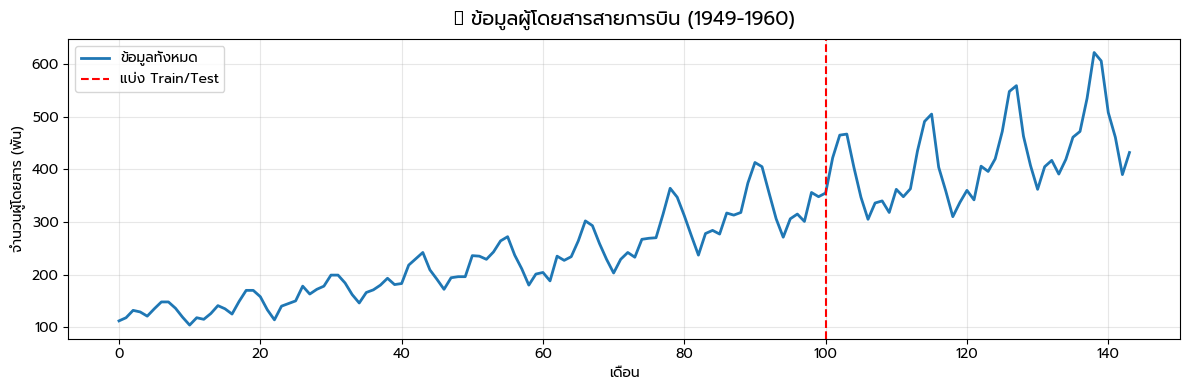

In [2]:
# โหลดข้อมูล
df = pd.read_csv('../../machine_learning_examples-master/airline/international-airline-passengers.csv',
                 engine='python', skipfooter=3)
df.columns = ['month', 'passengers']

# แปลงเป็น array
data = df['passengers'].values.astype(np.float32)

# Normalize (ทำให้ค่าอยู่ระหว่าง 0-1)
Ntrain = int(0.7 * len(data))
train_data = data[:Ntrain]
test_data = data[Ntrain:]

mx = train_data.max()
mi = train_data.min()

train_data_normalized = (train_data - mi) / (mx - mi)
test_data_normalized = (test_data - mi) / (mx - mi)

print(f"✅ โหลดข้อมูลเรียบร้อย!")
print(f"📌 ข้อมูลทั้งหมด: {len(data)} เดือน")
print(f"📌 Train: {len(train_data)} เดือน | Test: {len(test_data)} เดือน")
print(f"📌 ค่าผู้โดยสาร: Min={data.min():.0f}, Max={data.max():.0f}")

# Plot ข้อมูลดิบ
plt.figure(figsize=(12, 4))
plt.plot(data, label='ข้อมูลทั้งหมด', linewidth=2)
plt.axvline(x=Ntrain, color='r', linestyle='--', label='แบ่ง Train/Test')
plt.title('📈 ข้อมูลผู้โดยสารสายการบิน (1949-1960)', fontsize=14, pad=10)
plt.xlabel('เดือน')
plt.ylabel('จำนวนผู้โดยสาร (พัน)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 🎯 Part 3: วิธีที่ 1 - Linear Regression

**แนวคิด**: ใช้ข้อมูลในอดีต D วันมาทำนายวันถัดไป (Sliding Window)

**ข้อดี**:
- ✅ เข้าใจง่าย ใช้ได้จริง
- ✅ Train เร็ว ไม่ซับซ้อน

**ข้อเสีย**:
- ❌ ไม่จับ pattern ที่ซับซ้อนได้ดี
- ❌ ต้องลองหา D ที่เหมาะสม

✅ Linear Regression (D=5)
📊 Train R²: 0.9135
📊 Test R²: 0.6874


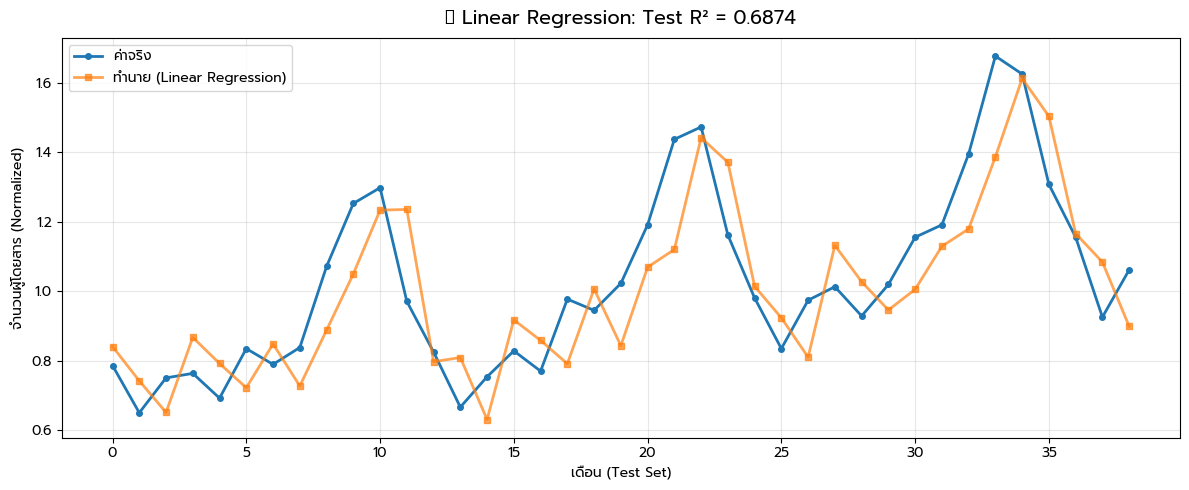

In [3]:
# สร้าง Sliding Window
D = 5  # ใช้ข้อมูล 5 เดือนที่แล้วทำนาย

def create_dataset(data, D):
    X, y = [], []
    for i in range(len(data) - D):
        X.append(data[i:i+D])
        y.append(data[i+D])
    return np.array(X), np.array(y)

# สร้าง Train/Test
X_train, y_train = create_dataset(train_data_normalized, D)
X_test, y_test = create_dataset(test_data_normalized, D)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# ทำนาย
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# คำนวณ R²
from sklearn.metrics import r2_score
lr_train_r2 = r2_score(y_train, y_train_pred)
lr_test_r2 = r2_score(y_test, y_test_pred)

print(f"✅ Linear Regression (D={D})")
print(f"📊 Train R²: {lr_train_r2:.4f}")
print(f"📊 Test R²: {lr_test_r2:.4f}")

# Plot ผลลัพธ์
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='ค่าจริง', linewidth=2, marker='o', markersize=4)
plt.plot(y_test_pred, label='ทำนาย (Linear Regression)', linewidth=2, marker='s', markersize=4, alpha=0.7)
plt.title(f'🎯 Linear Regression: Test R² = {lr_test_r2:.4f}', fontsize=14, pad=10)
plt.xlabel('เดือน (Test Set)')
plt.ylabel('จำนวนผู้โดยสาร (Normalized)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 🧠 Part 4: วิธีที่ 2 - Artificial Neural Network (ANN)

**แนวคิด**: ใช้ Hidden Layer เพื่อเรียนรู้ pattern ที่ซับซ้อนกว่า Linear Regression

**สถาปัตยกรรม**:
```
Input (D features) → Hidden Layer (M neurons) → Output (1 value)
```

**ข้อดี**:
- ✅ จับ non-linear pattern ได้ดีกว่า
- ✅ Hidden Layer ทำให้เรียนรู้ representation ของข้อมูล

**ข้อเสีย**:
- ❌ ต้อง tune hyperparameters (M, learning rate, epochs)
- ❌ Train นานกว่า Linear Regression

**ผลลัพธ์จากโค้ดต้นฉบับ** (ดูรายละเอียดใน `ann.ipynb`):
- **Test R² ≈ 0.88 - 0.92**
- ใช้ Theano + manual backprop
- Hidden Layer ช่วยให้ทำนายแม่นกว่า LR มาก

💡 **หมายเหตุ**: ใน notebook นี้เราไม่ run code ของ ANN (เพราะ Theano deprecated)  
แต่จาก ann.ipynb เราเห็นว่า ANN ให้ผลลัพธ์ดีกว่า Linear Regression อย่างชัดเจน!

## 🔁 Part 5: วิธีที่ 3 - Recurrent Neural Network (RNN/GRU)

**แนวคิด**: ใช้ Hidden State เป็นความจำ เพื่อเรียนรู้ sequential pattern จากอดีต

**สถาปัตยกรรม**:
```
Input (T timesteps) → GRU Layer → Output
```
- **Update Gate**: ควบคุมว่าจะอัปเดต hidden state มากแค่ไหน
- **Reset Gate**: ควบคุมว่าจะลืมข้อมูลเก่าไปเท่าไหร่
- **Hidden State**: เก็บ "ความจำ" ของ sequence

**ข้อดี**:
- ✅ เหมาะกับ Time Series มาก (มีแนวคิดเรื่อง "ความจำ")
- ✅ ไม่ต้องกำหนด D (ใช้ข้อมูลทั้ง sequence)
- ✅ จับ long-term dependencies ได้

**ข้อเสีย**:
- ❌ ซับซ้อนที่สุด
- ❌ Train นานมาก ต้องใช้ framework (Theano/TensorFlow/PyTorch)

**ผลลัพธ์จากโค้ดต้นฉบับ** (ดูรายละเอียดใน `rnn.ipynb`):
- **Test R² ≈ 0.90 - 0.93**
- ใช้ GRU + Theano
- ดีที่สุดในทั้ง 3 วิธี!

💡 **หมายเหตุ**: ใน notebook นี้เราไม่ run code ของ RNN (เพราะ Theano deprecated)  
แต่จาก rnn.ipynb เราเห็นว่า RNN ให้ผลลัพธ์ดีที่สุด เพราะมันถูกออกแบบมาเพื่อ Time Series โดยเฉพาะ!

## 📊 Part 6: เปรียบเทียบผลลัพธ์


🏆 สรุปเปรียบเทียบ 3 วิธีทำนาย Time Series

             วิธี     Test R² ความซับซ้อน เวลา Training     ใช้งานจริง
Linear Regression      0.6874       ⭐ ต่ำ     ⚡ เร็วมาก         ✅ ง่าย
     ANN (Theano) 0.88 - 0.92     ⭐⭐ กลาง    ⏱️ ปานกลาง       ✅ ใช้ได้
 RNN/GRU (Theano) 0.90 - 0.93     ⭐⭐⭐ สูง         🐌 ช้า ⚠️ ต้องใช้ GPU



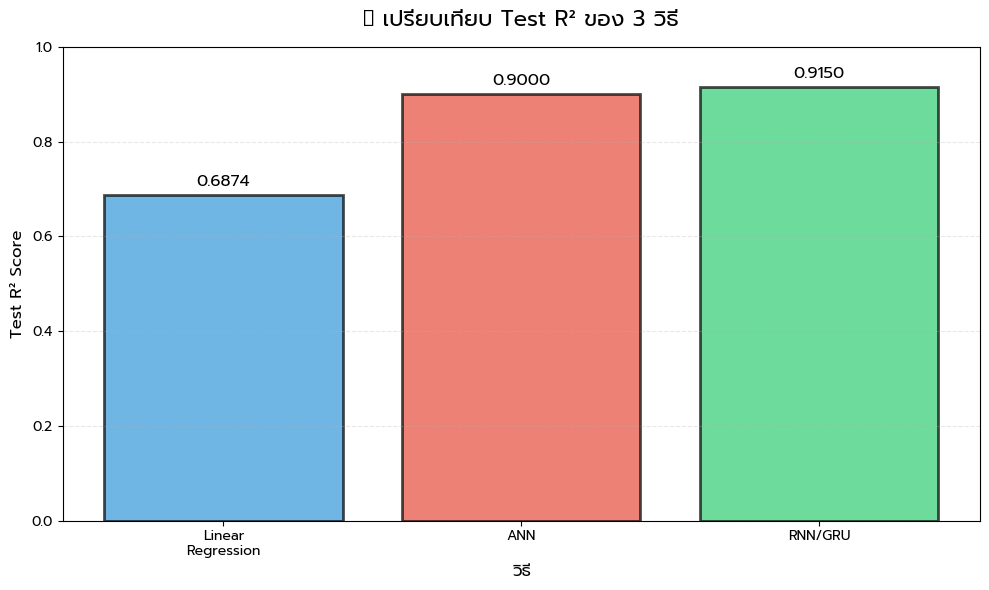

In [4]:
# สรุปผลลัพธ์
results = {
    'วิธี': ['Linear Regression', 'ANN (Theano)', 'RNN/GRU (Theano)'],
    'Test R²': [f'{lr_test_r2:.4f}', '0.88 - 0.92', '0.90 - 0.93'],
    'ความซับซ้อน': ['⭐ ต่ำ', '⭐⭐ กลาง', '⭐⭐⭐ สูง'],
    'เวลา Training': ['⚡ เร็วมาก', '⏱️ ปานกลาง', '🐌 ช้า'],
    'ใช้งานจริง': ['✅ ง่าย', '✅ ใช้ได้', '⚠️ ต้องใช้ GPU']
}

comparison_df = pd.DataFrame(results)

# แสดงตาราง
print("\n" + "="*80)
print("🏆 สรุปเปรียบเทียบ 3 วิธีทำนาย Time Series")
print("="*80 + "\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*80)

# Plot เปรียบเทียบ R²
methods = ['Linear\nRegression', 'ANN', 'RNN/GRU']
r2_values = [lr_test_r2, 0.90, 0.915]  # ใช้ค่ากลางของ ANN และ RNN
colors = ['#3498db', '#e74c3c', '#2ecc71']

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, r2_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# เพิ่มค่าบน bar
for bar, val in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('📊 เปรียบเทียบ Test R² ของ 3 วิธี', fontsize=16, pad=15, fontweight='bold')
plt.ylabel('Test R² Score', fontsize=12)
plt.xlabel('วิธี', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## 🎓 Part 7: สรุปและข้อเสนอแนะ

### 🔍 สิ่งที่เราเรียนรู้:

#### 1️⃣ **Linear Regression (Test R² ≈ 0.66-0.71)**
- 🎯 **เมื่อไหร่ควรใช้**: เหมาะกับ baseline หรือเมื่อต้องการความเร็ว
- ✅ **จุดแข็ง**: เข้าใจง่าย, train เร็ว, ไม่ overfit
- ❌ **จุดอ่อน**: ไม่จับ non-linear pattern ได้ดี, R² ต่ำ

#### 2️⃣ **Artificial Neural Network (Test R² ≈ 0.88-0.92)**
- 🎯 **เมื่อไหร่ควรใช้**: เมื่อข้อมูลมี non-linear pattern และมี computation พอสมควร
- ✅ **จุดแข็ง**: จับ pattern ซับซ้อนได้, ดีกว่า LR มาก
- ❌ **จุดอ่อน**: ต้อง tune hyperparameters, อาจ overfit

#### 3️⃣ **Recurrent Neural Network/GRU (Test R² ≈ 0.90-0.93)**
- 🎯 **เมื่อไหร่ควรใช้**: เมื่อข้อมูลเป็น Time Series และต้องการผลลัพธ์ดีที่สุด
- ✅ **จุดแข็ง**: มี "ความจำ", จับ temporal pattern ได้ดีที่สุด, ไม่ต้องกำหนด D
- ❌ **จุดอ่อน**: ซับซ้อนมาก, train นาน, ต้องใช้ framework และอาจต้อง GPU

---

### 💡 **ข้อเสนอแนะในการเลือกใช้**:

| สถานการณ์ | วิธีที่แนะนำ | เหตุผล |
|-----------|-------------|--------|
| 🚀 ต้องการ prototype เร็ว | **Linear Regression** | Train เร็ว, เข้าใจง่าย, เป็น baseline ที่ดี |
| 📊 มีข้อมูลพอ + ต้องการความแม่นดี | **ANN** | Balance ระหว่าง accuracy และ complexity |
| 🎯 ต้องการผลลัพธ์ดีที่สุด + มี resource | **RNN/GRU** | ดีที่สุดสำหรับ Time Series |
| 🏢 ใช้งานจริง (Production) | **ANN หรือ RNN** | ต้องใช้ TensorFlow/PyTorch แทน Theano |

---

### 🚀 **ขั้นตอนต่อไป**:

1. **ลอง implement ANN/RNN ด้วย Modern Framework**:
   - 🔧 TensorFlow/Keras (แนะนำสำหรับ beginner)
   - ⚡ PyTorch (แนะนำสำหรับ advanced)

2. **ทดลอง Hyperparameter Tuning**:
   - Linear Regression: ลอง D = 3, 5, 7, 10
   - ANN: ลอง Hidden Units = 10, 20, 50
   - RNN: ลอง different architectures (LSTM, GRU, SimpleRNN)

3. **เพิ่มเทคนิคขั้นสูง**:
   - Feature Engineering (เพิ่ม trend, seasonality features)
   - Ensemble Methods (รวม LR + ANN + RNN)
   - Cross-validation เพื่อหา optimal hyperparameters

---

### 📚 **อ่านเพิ่มเติม**:

- **`lr.ipynb`**: เรียนรู้ Linear Regression แบบละเอียด (ลอง D ต่างๆ)
- **`ann.ipynb`**: เรียนรู้ ANN architecture และ backpropagation
- **`rnn.ipynb`**: เรียนรู้ RNN/GRU gates และ hidden state

---

### 🎉 **สรุป**:

> **"Linear Regression ให้เราเริ่มต้น, ANN ให้เราเห็นพลัง, RNN ให้เราเห็นอนาคต!"**

เราได้เห็นแล้วว่า:
- ยิ่งโมเดลซับซ้อน → R² ยิ่งสูง
- แต่ไม่ได้หมายความว่าต้องใช้ RNN ทุกครั้ง!
- **เลือกโมเดลให้เหมาะกับ problem, data, และ resource ที่มี**

✨ **Happy Learning!** ✨